- SIGNATE お弁当の売り上げをLightGBMで予測してみた

https://qiita.com/chusan/items/d7b210243f3b646375ba
    
- Pythonで時系列分析の練習（6）トレンド、季節性、残差に分解

https://momonoki2017.blogspot.com/2018/03/python6.html

In [1]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [2]:
# sales_history_df = pd.read_csv('./inputs/sales_history.csv')
# category_names_df = pd.read_csv('./inputs/category_names.csv')
# item_categories_df = pd.read_csv('./inputs/item_categories.csv')

In [3]:
# sales_history_addfeature_df = pd.read_pickle('./inputs/sales_history_addfeature1.pickle')
item_categories_df = pd.read_pickle('./inputs/item_categories_addname.pickle')
test_df = pd.read_csv('./inputs/test.csv')
sub = pd.read_csv('./inputs/sample_submission.csv', header=None)

In [16]:
train_merged_data = pd.read_pickle('./inputs/train_merged_data.pickle')
data = pd.read_pickle('./inputs/dataset_addfeature_lag_trend_clusters.pickle')

In [5]:
train_merged_data

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,holiday,holiday_cat,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,月ブロック,month_cos,month_sin,weekday_cos,weekday_sin,day_cos,day_sin,売上金額,商品価格_is_0
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.500000,1.0,0.000000e+00,0.97953,2.012985e-01,420.0,0
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.500000,1.0,0.000000e+00,0.97953,2.012985e-01,420.0,0
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.500000,1.0,0.000000e+00,0.97953,2.012985e-01,420.0,0
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.500000,1.0,0.000000e+00,0.97953,2.012985e-01,250.0,0
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,1,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD,None,0,0.866025,0.500000,1.0,0.000000e+00,0.97953,2.012985e-01,250.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,340,ゲーム周辺機器 - ゲーム機A,0,0,2019,10,31,2019,10,31,木曜日,3,ゲーム周辺機器,ゲーム機A,None,21,0.500000,-0.866025,-1.0,1.224647e-16,1.00000,-2.449294e-16,2700.0,0
1119566,2019-10-31,7,3400009,1020,1.0,340,ゲーム周辺機器 - ゲーム機A,0,0,2019,10,31,2019,10,31,木曜日,3,ゲーム周辺機器,ゲーム機A,None,21,0.500000,-0.866025,-1.0,1.224647e-16,1.00000,-2.449294e-16,1020.0,0
1119567,2019-10-31,7,3400012,510,1.0,340,ゲーム周辺機器 - ゲーム機A,0,0,2019,10,31,2019,10,31,木曜日,3,ゲーム周辺機器,ゲーム機A,None,21,0.500000,-0.866025,-1.0,1.224647e-16,1.00000,-2.449294e-16,510.0,0
1119568,2019-10-31,4,3500001,340,1.0,350,本 - オーディオブック_タイプB,0,0,2019,10,31,2019,10,31,木曜日,3,本,オーディオブック,タイプB,21,0.500000,-0.866025,-1.0,1.224647e-16,1.00000,-2.449294e-16,340.0,0


In [17]:
data

,月ブロック,店舗ID,商品ID,売上個数,year_cat,month_cat,year,month,月ブロック_cat,holiday_cnt,month_cos,month_sin,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean_lag_7,売上個数_date_catnamemean_lag_8,売上個数_date_catnamemean_lag_9,売上個数_date_catnamemean_lag_10,売上

# Single series

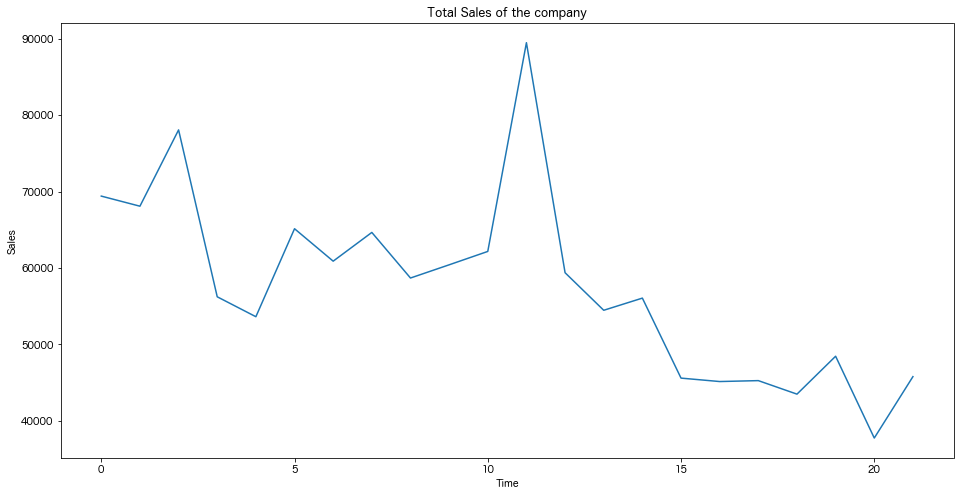

In [6]:
#ts
ts=train_merged_data.groupby(["月ブロック"])["売上個数"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [7]:
ts

月ブロック
0     69404.0
1     68082.5
2     78069.0
3     56226.0
4     53618.0
5     65134.5
6     60889.0
7     64649.5
8     58682.5
9     60410.5
10    62162.0
11    89483.5
12    59377.0
13    54461.0
14    56053.0
15    45582.0
16    45134.0
17    45254.0
18    43485.5
19    48446.0
20    37740.0
21    45775.0
Name: 売上個数, dtype: float64

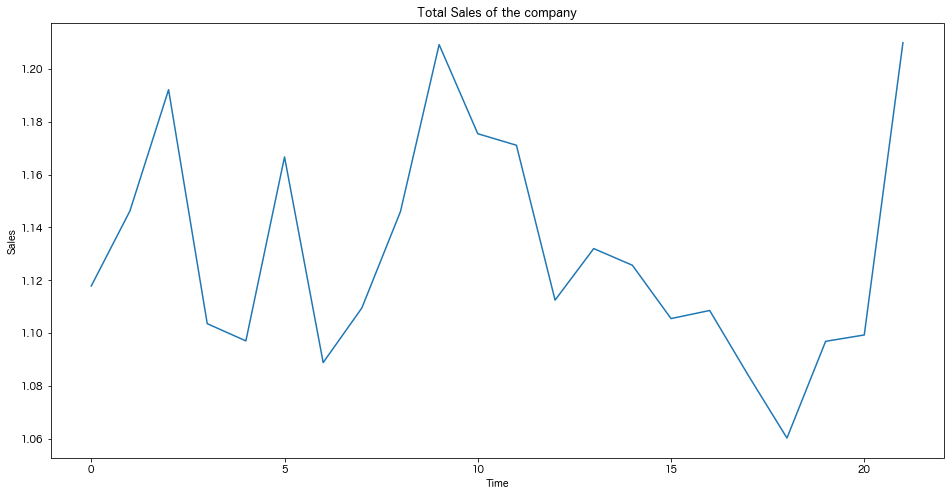

In [15]:
#ts
ts_mean=train_merged_data.groupby(["月ブロック"])["売上個数"].mean()
ts_mean.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_mean);

In [14]:
ts_mean

月ブロック
0     1.117851
1     1.146267
2     1.192184
3     1.103574
4     1.097043
5     1.166720
6     1.088840
7     1.109501
8     1.146053
9     1.209274
10    1.175507
11    1.171143
12    1.112491
13    1.132010
14    1.125698
15    1.105501
16    1.108562
17    1.083980
18    1.060260
19    1.096882
20    1.099298
21    1.209987
Name: 売上個数, dtype: float64

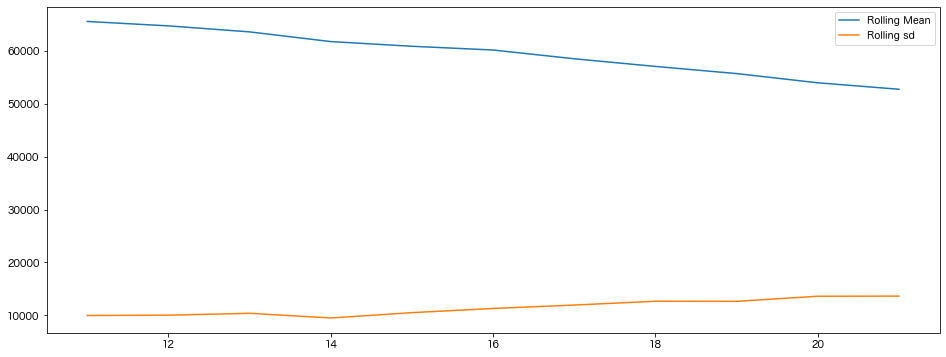

In [8]:
#pandasで窓関数を適用するrollingを使って移動平均などを算出
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**簡単な観察**  
明らかな「季節性」（例：1年のある時期のピーク売上）と減少する「傾向」があります。

トレンド、季節性、残差にすばやく分解して確認しましょう。

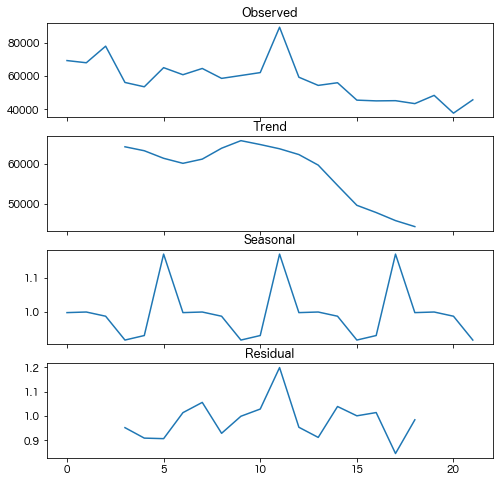

In [9]:
import statsmodels.api as sm
# 時系列データを傾向変動・季節変動・残差に分解する
decompose_result = sm.tsa.seasonal_decompose(ts.values,freq=6,
                                             # 乗法モデルを仮定する
                                             model='multiplicative')

# これでもグラフが描ける
# decompose_result.plot()

# 描画する領域を用意する
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.show()

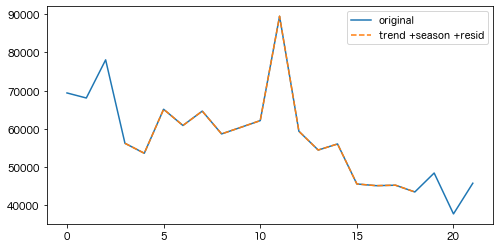

In [12]:
sum_three_data = decompose_result.trend + decompose_result.seasonal + decompose_result.resid # トレンド + 季節性 + 残差

plt.figure(figsize=(8, 4)) # グラフ描画枠作成、サイズ指定
plt.plot(decompose_result.observed, label='original')
plt.plot(sum_three_data, label='trend +season +resid', linestyle='--')
plt.legend(loc='best') # 凡例表示

ちゃんと一致する

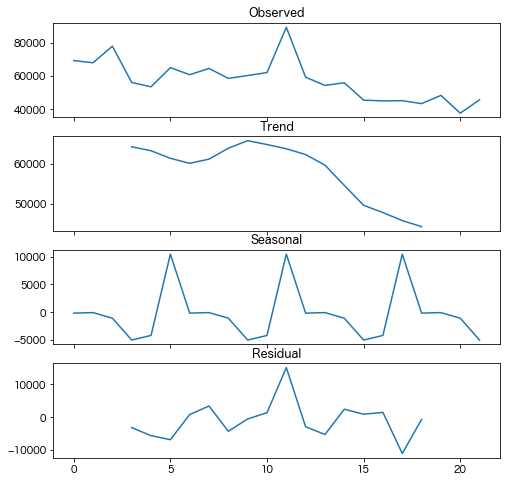

In [10]:
# 時系列データを傾向変動・季節変動・残差に分解する
decompose_result = sm.tsa.seasonal_decompose(ts.values,freq=6,
                                             # 乗法モデルを仮定する
                                             model='additive')

# これでもグラフが描ける
# decompose_result.plot()

# 描画する領域を用意する
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.show()

加法モデルを想定すると、次のように書くことができます。


> yt=St+Tt+Et 

ここで、ytは期間tのデータ、Stは期間tの季節成分、Ttは期間ttの傾向サイクル成分、Etは期間tの剰余（または不規則または誤差）成分です。乗法モデルの場合も同様です。

> yt=St  x Tt x Et 

## 定常性:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

定常性とは、系列の時不変を指します。 （ie）時系列の2つのポイントは、方向（順方向/逆方向）ではなく、それらがどれだけ離れているかによってのみ相互に関連しています。

時系列が定常である場合、モデル化が容易になる可能性があります。 統計モデリング手法では、時系列が静止していると想定または必要です。

定常性をチェックするために使用できる複数のテストがあります。
* ADF（拡張ディッキーフラー検定）
* KPSS
* PP（フィリップス-ペロン検定）

最も一般的に使用されているADFを実行してみましょう。

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)



In [40]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.387002
p-value                         0.145439
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [41]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

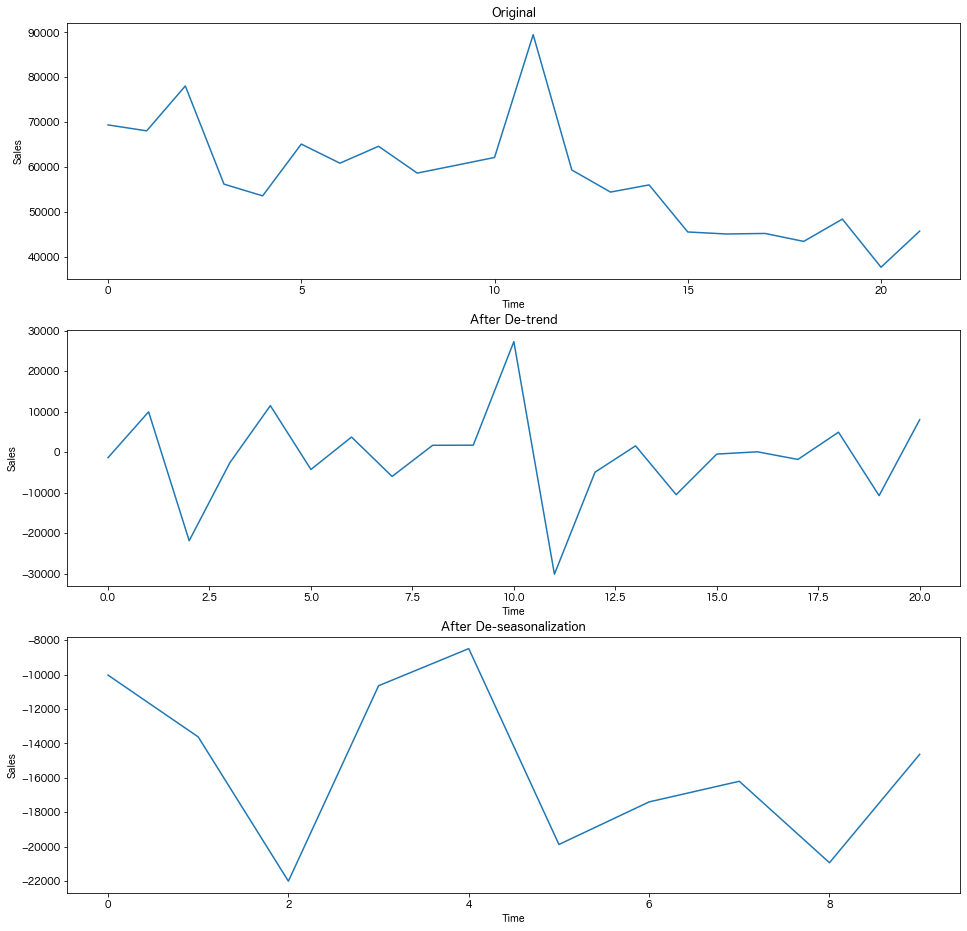

In [42]:
ts=train_merged_data.groupby(["月ブロック"])["売上個数"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [44]:
new_ts

0   -10027.0
1   -13621.5
2   -22016.0
3   -10644.0
4    -8484.0
5   -19880.5
6   -17403.5
7   -16203.5
8   -20942.5
9   -14635.5
dtype: float64

In [43]:
# 季節性がなくなった後、定常性を再度テストします
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -3.304061
p-value                        0.014698
#Lags Used                     3.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


## 型

In [20]:
cat_col = [col for col in data.select_dtypes(include=object)]
num_col = [col for col in data.select_dtypes(exclude=object)]

# 関数

In [21]:
#説明変数を対数変換
def logarithmic_transformation(df):
    num_col = [col for col in df.select_dtypes(exclude=object)]
    
    print(num_col)
    #各説明変数の歪度を計算
    skewed_feats = df[num_col].apply(lambda x: x.skew()).sort_values(ascending = False)
    
    #歪度の絶対値が0.5より大きい変数だけに絞る
    skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5]
    
    #欠損値のないものに絞る
    num_col_feat_list = []
    for i in skewed_feats_over.index:
        flag = df[i].isnull().any()
        if not flag:
            num_col_feat_list.append(i)

    print(num_col_feat_list)
    
    #グラフ化
    skewed_feats_over_plot = skewed_feats_over[num_col_feat_list]
    
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_over_plot.index, y=skewed_feats_over_plot)
    
    #Yeo-Johnson変換
    pt = PowerTransformer()
    pt.fit(df[num_col_feat_list])

    #変換後のデータで各列を置換
    tmp = pd.DataFrame()
    tmp[num_col_feat_list] = pt.transform(df[num_col_feat_list])
    tmp = tmp.add_prefix('Log_')
    df[tmp.columns] = tmp
    
    #各説明変数の歪度を計算
    skewed_feats_fixed = df[tmp.columns].apply(lambda x:x.skew()).sort_values(ascending = False)

    #グラフ化
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='90')
    sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

    return df, num_col_feat_list, pt

"""=================================================="""

#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    #df2 = pd.get_dummies(df2, drop_first=True)
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

"""=================================================="""

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# データセットの整理

In [22]:
X_data = data[(data['月ブロック'] >= 12)].drop(['売上個数'], axis=1)
y_data = data[(data['月ブロック'] >= 12)]['売上個数']

In [23]:
X_data

,月ブロック,店舗ID,商品ID,year_cat,month_cat,year,month,月ブロック_cat,holiday_cnt,month_cos,month_sin,商品カテゴリID,商品カテゴリ名,商品カテゴリ_type1,商品カテゴリ_type2,商品カテゴリ_type3,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean_lag_7,売上個数_date_catnamemean_lag_8,売上個数_date_catnamemean_lag_9,売上個数_date_catnamemean_lag_10,売上個数_da

In [24]:
y_data

331704     2.0
331705     0.0
331706     0.0
331707     0.0
331708     1.0
          ... 
1655023    NaN
1655024    NaN
1655025    NaN
1655026    NaN
1655027    NaN
Name: 売上個数, Length: 665946, dtype: float64

## カテゴリ変数化

In [25]:
cat_col

['店舗ID',
 '商品ID',
 'year_cat',
 'month_cat',
 '月ブロック_cat',
 '商品カテゴリID',
 '商品カテゴリ名',
 '商品カテゴリ_type1',
 '商品カテゴリ_type2',
 '商品カテゴリ_type3',
 '店舗別_売上個数_クラスタ_cat',
 '商品別_売上個数_クラスタ_cat']

In [26]:
for cat in cat_col:
    print(cat)
    print(X_data[cat].nunique(dropna=False))
    print('*' * 100)

店舗ID
18
****************************************************************************************************
商品ID
6629
****************************************************************************************************
year_cat
1
****************************************************************************************************
month_cat
12
****************************************************************************************************
月ブロック_cat
12
****************************************************************************************************
商品カテゴリID
26
****************************************************************************************************
商品カテゴリ名
26
****************************************************************************************************
商品カテゴリ_type1
8
****************************************************************************************************
商品カテゴリ_type2
22
***********************************************************************************

In [27]:
#labelencodingするカラム → コメントアウト one-hot変換
labelencoding_columns = [
    #'店舗ID',
 '商品ID',
 #'year_cat',
 #'month_cat',
 #'月ブロック_cat',
 '商品カテゴリ名',
 #'商品カテゴリ_type1',
 #'商品カテゴリ_type2',
 #'商品カテゴリ_type3',
#'店舗別_売上個数_クラスタ_cat',
 #'商品別_売上個数_クラスタ_cat'
]

X_data_dummy = process_categorical(X_data, labelencoding_columns)

  0%|          | 0/2 [00:00<?, ?it/s]

# データセットを入力値、目標値に分割

In [14]:
# 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
X_trainval = X_data_dummy[(X_data_dummy.月ブロック >= 12) & (X_data_dummy.月ブロック <= 22)]
y_trainval = y_data[(X_data_dummy.月ブロック>= 12) & (X_data_dummy.月ブロック <= 22)] #1 ~ 11月

X_test = X_data_dummy[X_data_dummy.月ブロック == 23] #12月

In [15]:
X_trainval

,月ブロック,商品ID,year,month,holiday_cnt,month_cos,month_sin,商品カテゴリ名,カテゴリ内_商品数,カテゴリtype1内_商品数,カテゴリtype2内_商品数,カテゴリtype3内_商品数,商品カテゴリ名_contains_ゲーム,商品カテゴリ名_contains_PC,売上個数_lag_1,売上個数_lag_2,売上個数_lag_3,売上個数_lag_4,売上個数_lag_5,売上個数_lag_6,売上個数_lag_7,売上個数_lag_8,売上個数_lag_9,売上個数_lag_10,売上個数_lag_11,売上個数_lag_12,売上個数_date_mean_lag_1,売上個数_date_mean_lag_2,売上個数_date_mean_lag_3,売上個数_date_mean_lag_4,売上個数_date_mean_lag_5,売上個数_date_mean_lag_6,売上個数_date_mean_lag_7,売上個数_date_mean_lag_8,売上個数_date_mean_lag_9,売上個数_date_mean_lag_10,売上個数_date_mean_lag_11,売上個数_date_mean_lag_12,売上個数_date_std_lag_1,売上個数_date_std_lag_2,売上個数_date_std_lag_3,売上個数_date_std_lag_4,売上個数_date_std_lag_5,売上個数_date_std_lag_6,売上個数_date_std_lag_7,売上個数_date_std_lag_8,売上個数_date_std_lag_9,売上個数_date_std_lag_10,売上個数_date_std_lag_11,売上個数_date_std_lag_12,売上個数_date_max_lag_1,売上個数_date_max_lag_2,売上個数_date_max_lag_3,売上個数_date_max_lag_4,売上個数_date_max_lag_5,売上個数_date_max_lag_6,売上個数_date_max_lag_7,売上個数_date_max_lag_8,売上個数_date_max_lag_9,売上個数_date_max_lag_10,売上個数_date_max_lag_11,売上個数_date_max_lag_12,売上個数_date_min_lag_1,売上個数_date_min_lag_2,売上個数_date_min_lag_3,売上個数_date_min_lag_4,売上個数_date_min_lag_5,売上個数_date_min_lag_6,売上個数_date_min_lag_7,売上個数_date_min_lag_8,売上個数_date_min_lag_9,売上個数_date_min_lag_10,売上個数_date_min_lag_11,売上個数_date_min_lag_12,売上個数_date_itemmean_lag_1,売上個数_date_itemmean_lag_2,売上個数_date_itemmean_lag_3,売上個数_date_itemmean_lag_4,売上個数_date_itemmean_lag_5,売上個数_date_itemmean_lag_6,売上個数_date_itemmean_lag_7,売上個数_date_itemmean_lag_8,売上個数_date_itemmean_lag_9,売上個数_date_itemmean_lag_10,売上個数_date_itemmean_lag_11,売上個数_date_itemmean_lag_12,売上個数_date_itemstd_lag_1,売上個数_date_itemstd_lag_2,売上個数_date_itemstd_lag_3,売上個数_date_itemstd_lag_4,売上個数_date_itemstd_lag_5,売上個数_date_itemstd_lag_6,売上個数_date_itemstd_lag_7,売上個数_date_itemstd_lag_8,売上個数_date_itemstd_lag_9,売上個数_date_itemstd_lag_10,売上個数_date_itemstd_lag_11,売上個数_date_itemstd_lag_12,売上個数_date_itemmax_lag_1,売上個数_date_itemmax_lag_2,売上個数_date_itemmax_lag_3,売上個数_date_itemmax_lag_4,売上個数_date_itemmax_lag_5,売上個数_date_itemmax_lag_6,売上個数_date_itemmax_lag_7,売上個数_date_itemmax_lag_8,売上個数_date_itemmax_lag_9,売上個数_date_itemmax_lag_10,売上個数_date_itemmax_lag_11,売上個数_date_itemmax_lag_12,売上個数_date_itemmin_lag_1,売上個数_date_itemmin_lag_2,売上個数_date_itemmin_lag_3,売上個数_date_itemmin_lag_4,売上個数_date_itemmin_lag_5,売上個数_date_itemmin_lag_6,売上個数_date_itemmin_lag_7,売上個数_date_itemmin_lag_8,売上個数_date_itemmin_lag_9,売上個数_date_itemmin_lag_10,売上個数_date_itemmin_lag_11,売上個数_date_itemmin_lag_12,売上個数_date_shopmean_lag_1,売上個数_date_shopmean_lag_2,売上個数_date_shopmean_lag_3,売上個数_date_shopmean_lag_4,売上個数_date_shopmean_lag_5,売上個数_date_shopmean_lag_6,売上個数_date_shopmean_lag_7,売上個数_date_shopmean_lag_8,売上個数_date_shopmean_lag_9,売上個数_date_shopmean_lag_10,売上個数_date_shopmean_lag_11,売上個数_date_shopmean_lag_12,売上個数_date_shopstd_lag_1,売上個数_date_shopstd_lag_2,売上個数_date_shopstd_lag_3,売上個数_date_shopstd_lag_4,売上個数_date_shopstd_lag_5,売上個数_date_shopstd_lag_6,売上個数_date_shopstd_lag_7,売上個数_date_shopstd_lag_8,売上個数_date_shopstd_lag_9,売上個数_date_shopstd_lag_10,売上個数_date_shopstd_lag_11,売上個数_date_shopstd_lag_12,売上個数_date_shopmax_lag_1,売上個数_date_shopmax_lag_2,売上個数_date_shopmax_lag_3,売上個数_date_shopmax_lag_4,売上個数_date_shopmax_lag_5,売上個数_date_shopmax_lag_6,売上個数_date_shopmax_lag_7,売上個数_date_shopmax_lag_8,売上個数_date_shopmax_lag_9,売上個数_date_shopmax_lag_10,売上個数_date_shopmax_lag_11,売上個数_date_shopmax_lag_12,売上個数_date_shopmin_lag_1,売上個数_date_shopmin_lag_2,売上個数_date_shopmin_lag_3,売上個数_date_shopmin_lag_4,売上個数_date_shopmin_lag_5,売上個数_date_shopmin_lag_6,売上個数_date_shopmin_lag_7,売上個数_date_shopmin_lag_8,売上個数_date_shopmin_lag_9,売上個数_date_shopmin_lag_10,売上個数_date_shopmin_lag_11,売上個数_date_shopmin_lag_12,売上個数_date_catnamemean_lag_1,売上個数_date_catnamemean_lag_2,売上個数_date_catnamemean_lag_3,売上個数_date_catnamemean_lag_4,売上個数_date_catnamemean_lag_5,売上個数_date_catnamemean_lag_6,売上個数_date_catnamemean_lag_7,売上個数_date_catnamemean_lag_8,売上個数_date_catnamemean_lag_9,売上個数_date_catnamemean_lag_10,売上個数_date_catnamemean_lag_11,売上個数_date_catnamemean_lag_12,売上個数_date_catnamestd_lag_1,売上個数

In [16]:
y_trainval

331704     2.000000
331705     0.000000
331706     0.000000
331707     0.000000
331708     1.000000
             ...   
1651963    0.844929
1651964    0.437225
1651965    0.455269
1651966    0.447218
1651967    0.470590
Name: 売上個数, Length: 662886, dtype: float64

# 目的変数の前処理

y_train
歪度: 13.955507
尖度: 442.545962
np.exp(train_y_log)
歪度: 2.162661
尖度: 5.520562
np.exp(train_y_log)
歪度: 1.409679
尖度: 0.941277


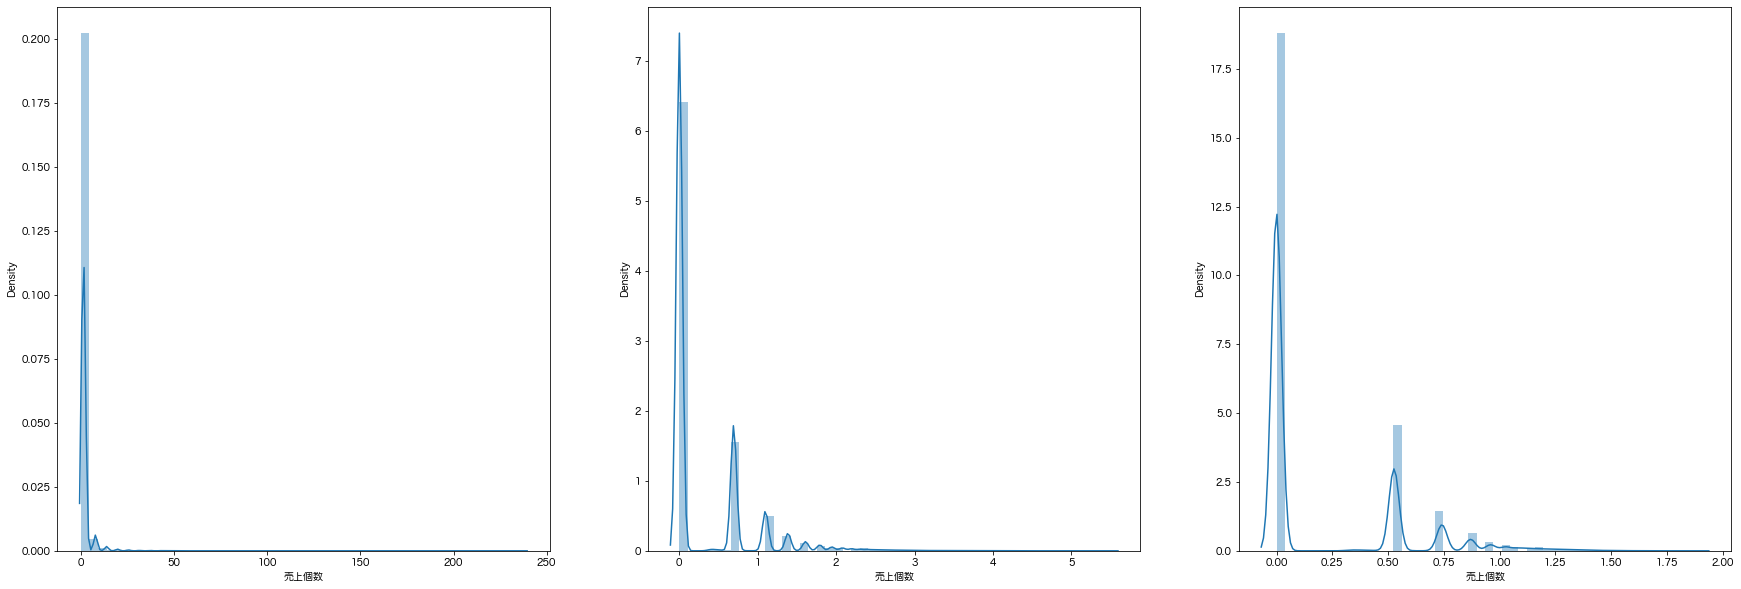

In [24]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 10])

sns.distplot(y_data[y_data.notnull()], ax=ax1)
#歪度と尖度を計算
print('y_train')
print("歪度: %f" % y_data.skew())
print("尖度: %f" % y_data.kurt())

print('=============')
y_data_log1p = np.log1p(y_data[y_data.notnull()])
sns.distplot(y_data_log1p, ax=ax2)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p.skew())
print("尖度: %f" % y_data_log1p.kurt())

print('=============')
y_data_log1p_log1p = np.log1p(y_data_log1p)
sns.distplot(y_data_log1p_log1p, ax=ax3)
print('np.exp(train_y_log)')
#歪度と尖度を計算
print("歪度: %f" % y_data_log1p_log1p.skew())
print("尖度: %f" % y_data_log1p_log1p.kurt())

In [32]:
data_p = data[['月ブロック', '売上個数']].copy()
data_p = data_p[(data_p.月ブロック >= 12) & (data_p.月ブロック <= 22)]
data_p.columns=['ds','y']
data_p

,ds,y
331704,12,2.000000
331705,12,0.000000
331706,12,0.000000
331707,12,0.000000
331708,12,1.000000
...,...,...
1651963,22,0.844929
1651964,22,0.437225
1651965,22,0.455269
1651966,22,0.447218


In [30]:
# 日付をインデックスとして時系列に追加する
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

NameError: name 'sales' is not defined

In [34]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(data_p) #fit the model with your dataframe

ValueError: Given date string not likely a datetime.